In [1]:
from pathlib import Path
from datetime import datetime, timedelta

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

sns.set_style('darkgrid')
pd.set_option("display.max_columns", None)

In [2]:
cols_1 = [
    "Salario mensual BRUTO (en tu moneda local)",
    "Salario mensual NETO (en tu moneda local)",
    "Recibís algún tipo de bono",
    "Años de experiencia",
    "Lenguajes de programación",
    "Nivel de estudios alcanzado",
    "Me identifico",
]

cols_2 = [
    "Salario mensual (en tu moneda local)",
    "¿Bruto o neto?",
    "Recibís algún tipo de bono",
    "Años de experiencia",
    "Tecnologías que utilizás.1",
    "Nivel de estudios alcanzado",
    "Me identifico",
]

meta = [
    {
        "name": "2021.1 - Encuesta Argentina.csv",
        "skiprows": 10,
        "columns": cols_1
    },
    {
        "name": "2020.2 - Encuesta Argentina.csv",
        "skiprows": 9,
        "columns": cols_1
    },
    {
        "name": "2020.1 - Encuesta Argentina.csv",
        "skiprows": 9,
        "columns": cols_1
    },
    {
        "name": "2019.2 - Encuesta Argentina.csv",
        "skiprows": 8,
        "columns": cols_1
    },
    {
        "name": "2019.1 - Encuesta.xlsx",
        "skiprows": 3,
        "columns": cols_1
    },
    {
        "name": "2018.2 - Encuesta.xlsx",
        "skiprows": 3,
        "columns": cols_2
    },
    {
        "name": "2018.1 - Encuesta.xlsx",
        "skiprows": 3,
        "columns": cols_2
    },
    {
        "name": "2017.2 - Encuesta.xlsx",
        "skiprows": 4,
        "columns": cols_2
    },
    {
        "name": "2017.1 - Encuesta.xlsx",
        "skiprows": 4,
        "columns": cols_2
    },
]

In [3]:
def split_neto_bruto(row):
    """
    La encuesta del 2017 y 2018 tiene una columna que indica si el
    salario es neto o burto. Lo divido en dos y calculo el
    otro teniendo en cuenta: bruto * 0.83 = neto
    """
    try:
        sueldo = float(row['Salario mensual (en tu moneda local)'])
    except:
        return None, None
    
    if row["¿Bruto o neto?"] == "Bruto":
        return sueldo, sueldo * 0.83
    else:
        return sueldo / 0.83, sueldo

dfs = []
for file in meta:
    print(f"Procesando archivo: {file['name']}")
    
    if file["name"].endswith(".csv"):
        df_partial = pd.read_csv(f"data/{file['name']}", skiprows=file["skiprows"])
    else:
        df_partial = pd.read_excel(f"data/{file['name']}", skiprows=file["skiprows"])

    df_partial = df_partial[file["columns"]]
    df_partial["fecha_encuesta"] = file["name"].split()[0]
    
    if file["columns"] == cols_2:
        df_partial["Lenguajes de programación"] = df_partial["Tecnologías que utilizás.1"]
        df_partial[[
            "Salario mensual BRUTO (en tu moneda local)",
            "Salario mensual NETO (en tu moneda local)"
        ]] = df_partial.apply(split_neto_bruto, axis=1, result_type="expand")
        df_partial = df_partial.drop(
            ["Salario mensual (en tu moneda local)", "¿Bruto o neto?", "Tecnologías que utilizás.1"],
            axis=1,
        )

    dfs.append(df_partial)

df = pd.concat(dfs)
df.columns = [
    'sueldo_bruto',
    'sueldo_neto',
    'recibis_bono',
    'anios_experiencia',
    'lenguajes_programación',
    'estudios',
    'me_identifico',
    'fecha_encuesta',
]

Procesando archivo: 2021.1 - Encuesta Argentina.csv
Procesando archivo: 2020.2 - Encuesta Argentina.csv
Procesando archivo: 2020.1 - Encuesta Argentina.csv
Procesando archivo: 2019.2 - Encuesta Argentina.csv
Procesando archivo: 2019.1 - Encuesta.xlsx
Procesando archivo: 2018.2 - Encuesta.xlsx
Procesando archivo: 2018.1 - Encuesta.xlsx
Procesando archivo: 2017.2 - Encuesta.xlsx
Procesando archivo: 2017.1 - Encuesta.xlsx


In [4]:
def format_dates(date):
    """
    Genero las fechas de las encuestas en base
    al nombre del archivo
    """
    year, i = date.split('.')    
    if i == "1":
        date = f"01/01/{year}"
    else:
        date = f"07/01/{year}"
        
    return datetime.strptime(date, "%m/%d/%Y").date()


def clear_bruto(sueldo):
    """
    Algunos sueldos brutos no son números
    o tienen algún comentario
    """
    try:
        return float(sueldo)
    except:
        return None


def clear_gender(genero):
    """
    Algunas personas (probablemente varones cis) escriben cosas bardeando a los otros generos autopercibidos.
    La solución fácil es mandarlos a None
    """
    if genero in ["hombre", "varon", "varón", "varón cis"]:
        return "varón"
    elif genero in ["mujer", "mujer cis"]:
        return "mujer"
    elif genero not in ["prefiero no decir", "otros", "no binarie"]:
        return None
    return genero


def gender_group(gender):
    if gender == 'varón':
        return 'varón'
    else:
        return 'no-varón'
    

# Limpio/normalizo algunos columnas
df.sueldo_bruto = df.sueldo_bruto.apply(clear_bruto)
df.me_identifico = df.me_identifico.str.lower().apply(clear_gender)
df["grupo"] = df.me_identifico.apply(gender_group)
df.fecha_encuesta = df.fecha_encuesta.apply(format_dates)

df.grupo = pd.Categorical(df.grupo)

In [5]:
# Dropeamos algunos valores que no nos sirven
total = len(df)
print(f"Total de finas: {total}")
df = df.dropna(subset=["sueldo_bruto", "sueldo_neto"])
print(f"Filas sin sueldo: {total - len(df)}\n")

total = len(df)
print(f"Total de finas: {total}")
df = df.dropna(subset=["lenguajes_programación"])
print(f"Filas de no programadores: {total - len(df)}\n")

total = len(df)
print(f"Total de finas: {total}")
df = df[(df.sueldo_neto > 3000) & (df.sueldo_neto < 1e6)]
print(f"Filas con sueldos invalidos: {total - len(df)}")

Total de finas: 41239
Filas sin sueldo: 1133

Total de finas: 40106
Filas de no programadores: 11925

Total de finas: 28181
Filas con sueldos invalidos: 991


In [6]:
df['sueldo_mensual_porcentual'] = df.sueldo_neto / df.sueldo_bruto
df['sueldo_en_blanco'] = (df.sueldo_mensual_porcentual >0.5) & (df.sueldo_mensual_porcentual <0.9) 

df = df.sort_values(by=['fecha_encuesta', 'sueldo_neto'])
df.head(10)

,sueldo_bruto,sueldo_neto,recibis_bono,anios_experiencia,lenguajes_programación,estudios,me_identifico,fecha_encuesta,grupo,sueldo_mensual_porcentual,sueldo_en_blanco
1452,4000.000000,3320.0,No,10+,PHP,NaN,varón,2017-07-01,varón,0.83,True
1638,4000.000000,3320.0,No,6,"C, C#, HTML, Java, Javascript, jQuery, Objecti...",NaN,varón,2017-07-01,varón,0.83,True
3198,4819.277108,4000.0,No,8,"CSS, HTML, Javascript, jQuery, PHP",NaN,varón,2017-07-01,varón,0.83,True
3679,4819.277108,4000.0,No,3,PHP,NaN,varón,2017-07-01,varón,0.83,True
3831,5000.000000,4150.0,No,Menos de un año,"CSS, HTML, Java, Javascript",NaN,varón,2017-07-01,varón,0.83,True
37,6024.096386,5000.0,Menos de un sueldo,Menos de un año,"Java, Javascript",NaN,varón,2017-07-01,varón,0.83,True
2023,6024.096386,5000.0,No,2,.NET,NaN,varón,2017-07-01,varón,0.83,True
3691,6024.096386,5000.0,Un sueldo,5,".NET, C#, HTML, Java, Javascript, PHP",NaN,varón,2017-07-01,varón,0.83,True
3814,6024.096386,5000.0,No,10+,".NET, VB *",NaN,varón,2017-07-01,varón,0.83,True
3971,6024.096386,5000.0,No,10+,"HTML, Java, Javascript",NaN,varón,2017-07-01,varón,0.83,True


In [7]:
df.groupby('fecha_encuesta')['fecha_encuesta'].count()

fecha_encuesta
2017-07-01    2382
2018-01-01    2012
2018-07-01    1028
2019-01-01    3382
2019-07-01    2421
2020-01-01    4557
2020-07-01    5687
2021-01-01    5721
Name: fecha_encuesta, dtype: int64

(0.0, 1000000.0)

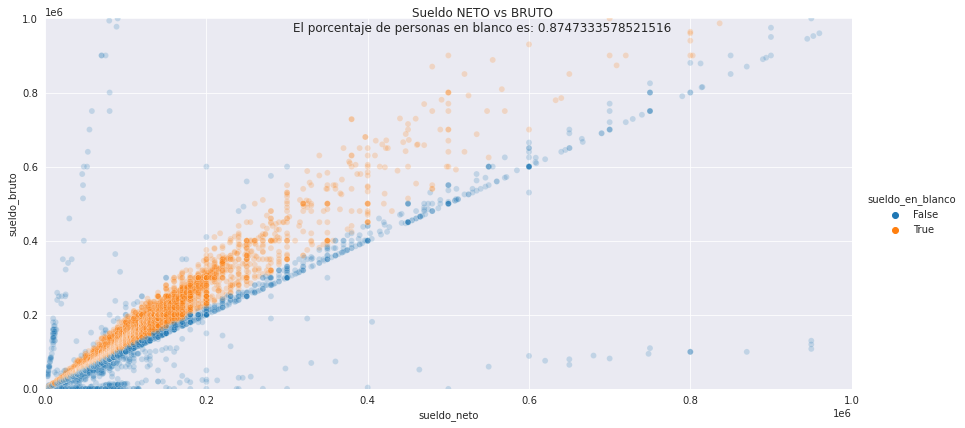

In [8]:
total_en_blanco = len(df[df.sueldo_en_blanco])
procentaje_en_blanco = total_en_blanco / len(df)

chart = sns.pairplot(
    data=df,
    x_vars=['sueldo_neto'],
    y_vars=['sueldo_bruto'],
    hue='sueldo_en_blanco',
    aspect=2,
    height=6,
    plot_kws=dict(alpha=0.2)
)
t = chart.fig.suptitle(f"Sueldo NETO vs BRUTO\nEl porcentaje de personas en blanco es: {procentaje_en_blanco}")

plt.xlim(0, 1e6)
plt.ylim(0, 1e6)

In [9]:
df_means = df[df.sueldo_en_blanco].groupby(["fecha_encuesta", "grupo"]) \
   .agg({'grupo': 'size', 'sueldo_neto': 'mean'}) \
   .rename(columns={'grupo':'cantidad','sueldo_neto':'sueldo_neto_promedio'}) \
   .reset_index()

df_means

,fecha_encuesta,grupo,cantidad,sueldo_neto_promedio
0,2017-07-01,no-varón,166,27186.209277
1,2017-07-01,varón,2216,30374.343402
2,2018-01-01,no-varón,190,27210.518105
3,2018-01-01,varón,1822,35355.868437
4,2018-07-01,no-varón,107,31867.230421
5,2018-07-01,varón,921,42865.823579
6,2019-01-01,no-varón,345,39570.411855
7,2019-01-01,varón,2483,48848.474583
8,2019-07-01,no-varón,272,48580.890257
9,2019-07-01,varón,1789,59723.257781


In [70]:
df_means.to_csv('sueldos_por_grupos.csv', index=False)

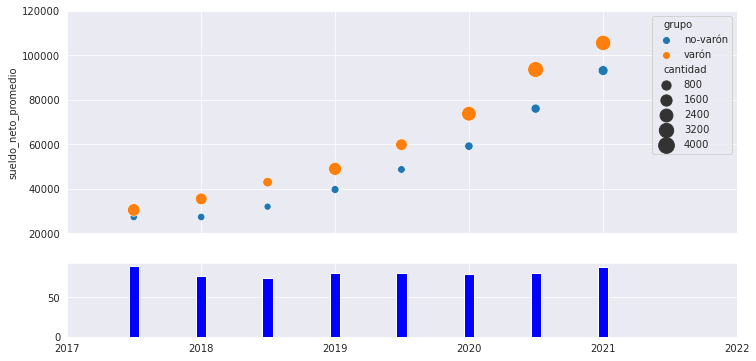

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

chart = sns.scatterplot(
    data=df_means,
    y='sueldo_neto_promedio',
    x='fecha_encuesta',
    size='cantidad',
    hue='grupo',
    sizes=(50, 250),
    zorder=200,
    ax=axs[0],
)

# Set axis lim and x interval
axs[0].set(
    xlim=[datetime.strptime("01/01/2017", "%m/%d/%Y").date(), datetime.strptime("01/01/2022", "%m/%d/%Y").date()],
    ylim=[20000, 120000],
)
axs[0].xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))

for date, group in df_means.groupby('fecha_encuesta'):
    sueldo_h = group[group.grupo == 'varón']['sueldo_neto_promedio'].values[0]
    sueldo_nh = group[group.grupo == 'no-varón']['sueldo_neto_promedio'].values[0]

    axs[1].bar(x=date, height=sueldo_nh*100/sueldo_h, width=timedelta(weeks=4), color="blue")

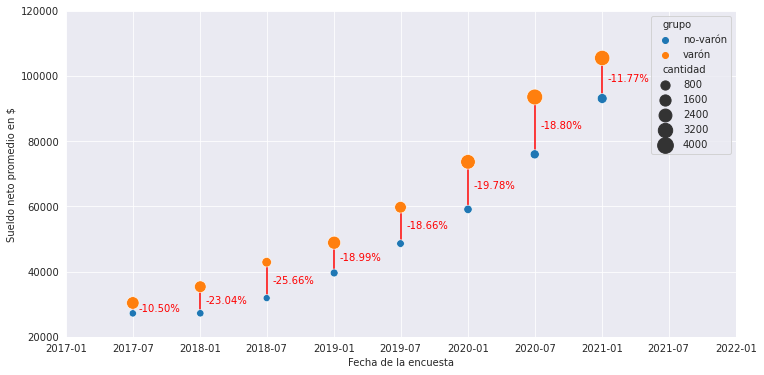

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

for date, group in df_means.groupby('fecha_encuesta'):
    y = group.sueldo_neto_promedio
    sueldo_h = group[group.grupo == 'varón']['sueldo_neto_promedio'].values[0]
    sueldo_nh = group[group.grupo == 'no-varón']['sueldo_neto_promedio'].values[0]

    ax.plot(
        [date, date],
        y,
        c='red'
    )
    
    ax.text(
        date + timedelta(days=15),
        y.mean(),
        f'-{100 - sueldo_nh*100/sueldo_h:.2f}%',
        verticalalignment='center',
        color="red"
    )
    
chart = sns.scatterplot(
    data=df_means,
    y='sueldo_neto_promedio',
    x='fecha_encuesta',
    size='cantidad',
    hue='grupo',
    sizes=(50, 250),
    zorder=200,
)

ax.set(
    xlim=[datetime.strptime("01/01/2017", "%m/%d/%Y").date(), datetime.strptime("01/01/2022", "%m/%d/%Y").date()],
    ylim=[20000, 120000],
)

# # Set x interval
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))

ax.set_ylabel("Sueldo neto promedio en $")
ax.set_xlabel("Fecha de la encuesta")
plt.savefig(fname="diff_sueldos_tweet.png", dpi=96)

In [11]:
# image resolution
dpi=96

# For each year:
for i in df_means.fecha_encuesta.unique():
 
    # Turn interactive plotting off
    plt.ioff()

    # initialize a figure
    fig, ax = plt.subplots(figsize=(680/dpi, 480/dpi), dpi=dpi)
    
    # Find the subset of the dataset for the current year
    subset = df_means[df_means.fecha_encuesta == i]
    
    ax.scatter(
        x=subset.fecha_encuesta, 
        y=subset.sueldo_neto_promedio,
        s=subset["cantidad"], 
        c=subset["grupo"].cat.codes, 
        cmap="Accent", 
        alpha=0.6, 
        edgecolors="white", 
        linewidth=2
    )

    ax.set(
        xlim=[datetime.strptime("01/01/2017", "%m/%d/%Y").date(), datetime.strptime("01/01/2022", "%m/%d/%Y").date()],
        ylim=[0, 120000],
    )

    date_form = DateFormatter("%Y-%m")
    ax.xaxis.set_major_formatter(date_form)

    # Set x interval
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    
    filename = f"imgs/encuesta-{i.strftime('%Y-%m')}"
    plt.savefig(fname=filename, dpi=96)
    plt.gca()
    plt.close(fig)

In [14]:
%%bash
convert -delay 80 imgs/encuesta-*.png sueldos_por_anios.gif